In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchmetrics import Accuracy

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Passo 2: Importar a base de dados

1. Criar uma conta no Kaggle;
2. No Kaggle, baixar o arquivo *kaggle.json*: Configurações -> API -> Criar novo Token

In [4]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p ~/kaggle/input/

!kaggle datasets download -d nikolasgegenava/sneakers-classification
!unzip  sneakers-classification.zip -d ~/kaggle/input/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0004.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0005.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0006.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0007.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0008.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0009.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0010.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0011.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-lyte_iii/0012.jpg  
  inflating: /root/kaggle/input/sneakers-dataset/sneakers-dataset/asics_gel-l

In [5]:
DATASET_INFO= "~/kaggle/input/dataset_stats.csv"
DATASET_BASE_PATH = '/root/kaggle/input/sneakers-dataset/sneakers-dataset/'

In [6]:
info = pd.read_csv(DATASET_INFO)
images = []
labels = []

for file in os.listdir(DATASET_BASE_PATH):
  for items in info["class"]:
    if file == items:
      for image in os.listdir(os.path.join(DATASET_BASE_PATH, file)):
        images.append(image)
        labels.append(items)

data = {'Imagens': images, 'Labels': labels}
data = pd.DataFrame(data)
data.head()

,Imagens,Labels
0,0013.jpg,nike_air_max_97
1,0085.jpg,nike_air_max_97
2,0021.jpg,nike_air_max_97
3,0081.jpg,nike_air_max_97
4,0018.jpg,nike_air_max_97


In [7]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['Labels'])
data.head()

,Imagens,Labels,encoded_labels
0,0013.jpg,nike_air_max_97,31
1,0085.jpg,nike_air_max_97,31
2,0021.jpg,nike_air_max_97,31
3,0081.jpg,nike_air_max_97,31
4,0018.jpg,nike_air_max_97,31


In [8]:
batch_size = 32
test_split = .3
shuffle_dataset = True
random_seed= 42

dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406, 0.4), (0.229, 0.224, 0.225, 0.230))
])

In [10]:
class Sneakers_Dataset(Dataset):
  def __init__ (self, img_data, img_path, transform=None):
    self.img_data = img_data
    self.img_path = img_path
    self.transform = transform

  def __len__(self):
    return len(self.img_data)

  def __getitem__(self, index):
    img_name = os.path.join(self.img_path,self.img_data.loc[index, 'Labels'], self.img_data.loc[index, 'Imagens'])
    img = Image.open(img_name)
    img = img.convert('RGBA')
    img = img.resize((300,300))

    label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])

    if self.transform is not None:
      img = self.transform(img)

    return img, label

In [11]:
dataset = Sneakers_Dataset(data, DATASET_BASE_PATH, transform)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler = test_sampler)

In [13]:
def img_display(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

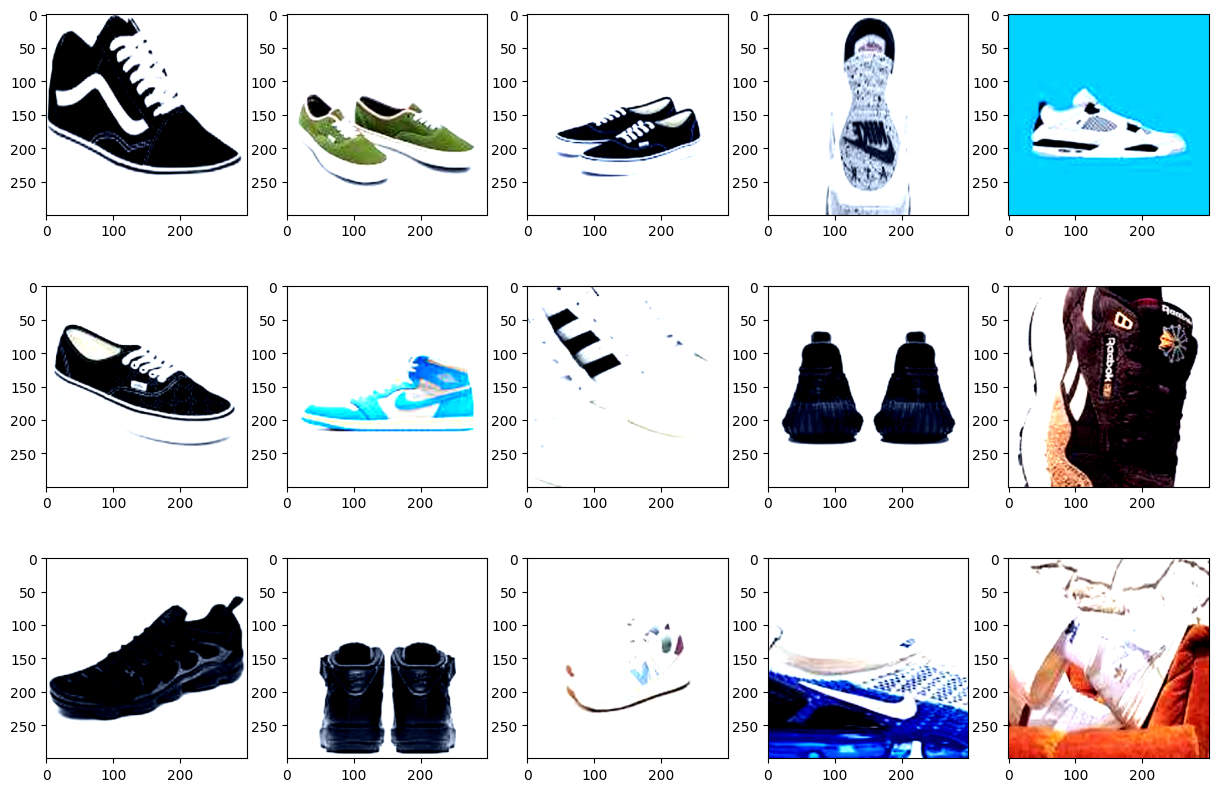

In [14]:
dataiter = iter(train_loader)

images, labels = dataiter.__next__()

fig, axis = plt.subplots(3, 5, figsize=(15, 10))

for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image))

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 50)
model = model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 77.5MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
num_epochs = 10
train_losses, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    acc_metric = Accuracy(task='multiclass', num_classes=50).to('cuda')

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            acc_metric(outputs, labels)

        accuracy = acc_metric.compute()
        val_accuracies.append(accuracy.item())

    train_losses.append(running_loss / len(train_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {train_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}')
    acc_metric.reset()

Epoch [1/10] | Loss: 2.9011 | Val Acc: 0.2984
Epoch [2/10] | Loss: 1.5882 | Val Acc: 0.5325
Epoch [3/10] | Loss: 1.0987 | Val Acc: 0.6321
Epoch [4/10] | Loss: 0.8686 | Val Acc: 0.6298
Epoch [5/10] | Loss: 0.6799 | Val Acc: 0.7079
Epoch [6/10] | Loss: 0.6209 | Val Acc: 0.7073
Epoch [7/10] | Loss: 0.4921 | Val Acc: 0.7147
Epoch [8/10] | Loss: 0.4013 | Val Acc: 0.7477
Epoch [9/10] | Loss: 0.4074 | Val Acc: 0.7437
Epoch [10/10] | Loss: 0.3494 | Val Acc: 0.7472


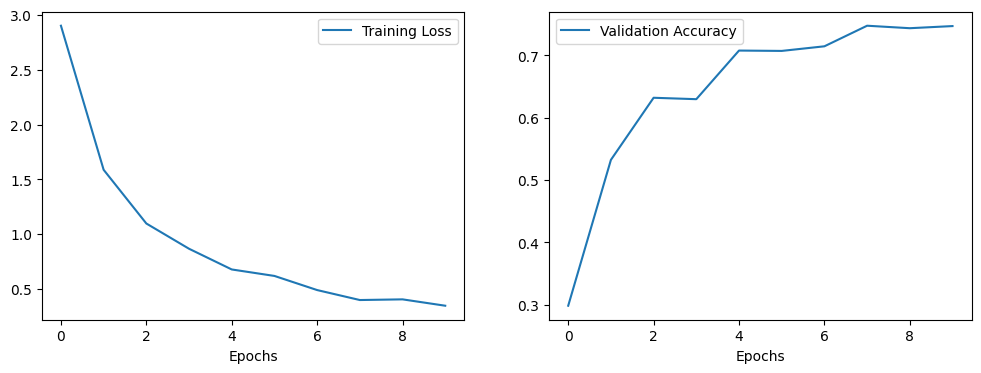

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

Test Accuracy: 0.7597


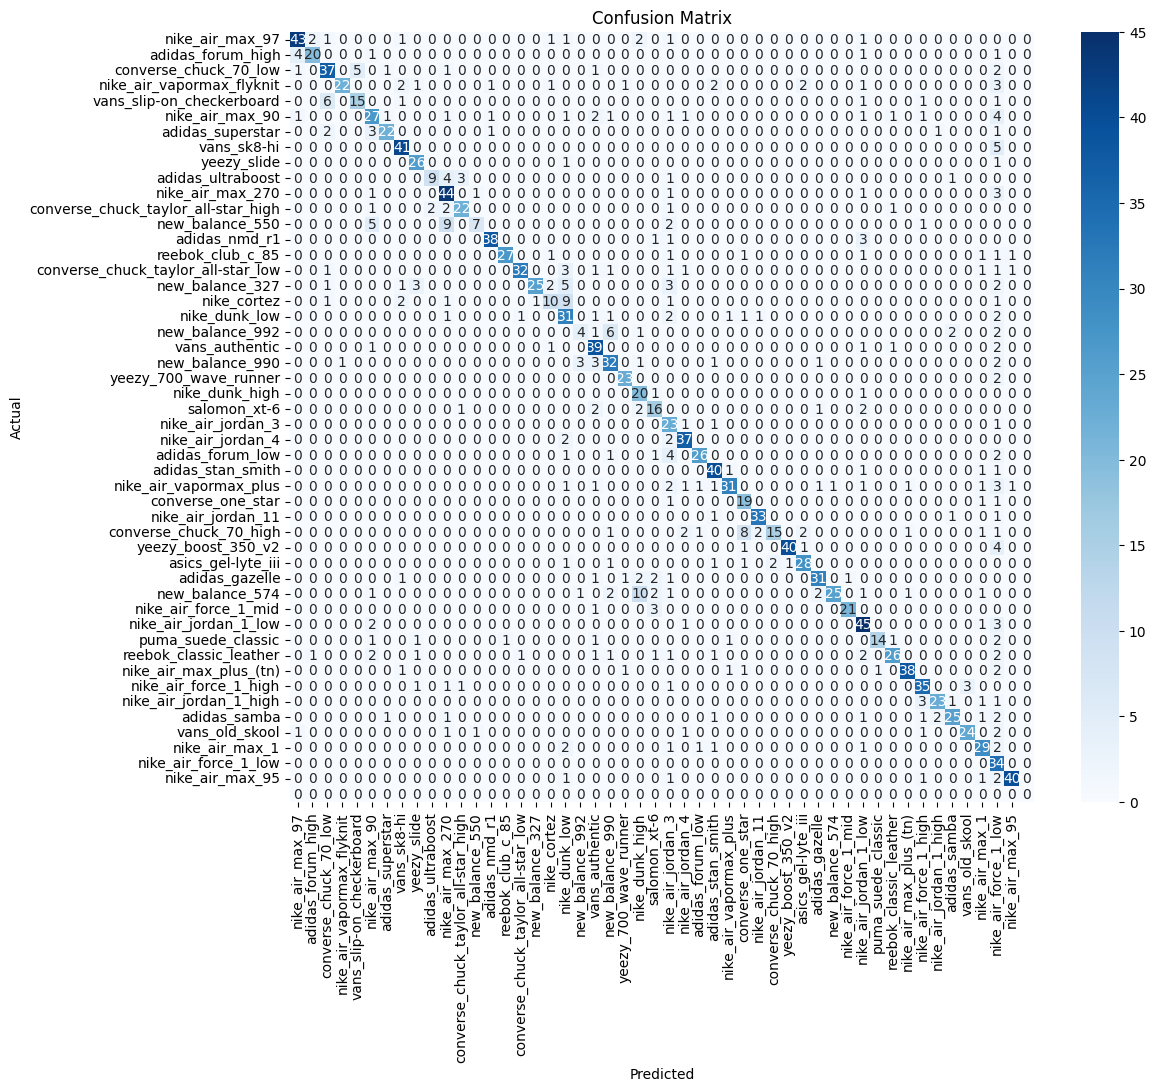

In [19]:
from torchmetrics import ConfusionMatrix
import seaborn as sns

model.eval()
test_acc = Accuracy(task='multiclass', num_classes=50).to('cuda')
confmat = ConfusionMatrix(task='multiclass', num_classes=50).to('cuda')

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        test_acc.update(outputs, labels)
        confmat.update(outputs, labels)

print(f'Test Accuracy: {test_acc.compute().item():.4f}')
cm = confmat.compute().cpu().numpy()


class_labels = data['Labels'].unique().tolist()


plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
torch.save(model.state_dict(), 'googlenet_sneakers.pth')

import json
with open('class_labels.json', 'w') as f:
    json.dump(data["Labels"].unique().tolist(), f)